<a href="https://colab.research.google.com/github/BuxinSu/ICML_Ranking/blob/main/Notebooks/No_submissions_vertical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Setting**

In [ ]:
from sklearn.isotonic import isotonic_regression
import cvxpy as cp
import numpy as np
import csv, os
from scipy import stats
from sklearn import metrics
import itertools
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statistics
from scipy.stats import levene
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set the text properties to use LaTeX fonts
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 28
plt.rcParams['figure.figsize'] = (10,20)  # width, height in inches
plt.rcParams['figure.dpi'] = 300  # dots per inch


# **Function: Partition all submissions according to "Greedy" and "Multi-owner" methods**


In [ ]:
def validate(partition, graph, n):
	# check that
	# 1. each paper is in exactly one partition
	# 2. the number of papers in all partition is equal to the number of papers
	# 3. each partition has at least two authors owns all papers in the partition

	papers = set()
	full_author_parts = []
	for part in partition[:-1]:
		assert( len(part.intersection(papers)) == 0 )
		papers |= part
		# find all authors that can rank all papers in this part
		cnt = 0
		author_part = set()
		for author, val in graph.items():
			if len(val.intersection(part)) == len(part):
				cnt += 1
				author_part.add(author)

		# assert( cnt >= 2 )
		full_author_parts.append(author_part)

	# add the last partition
	full_author_parts.append(set())
	papers |= partition[-1]
	assert(len(papers) == n)

	return full_author_parts


def greedy(graph, m, n, randomize=False, level=1):
	partition = []
	author_parts = []
	allocated_papers = set()


	if level == 1:
		parts = [ graph[i].copy() for i in range(m) ]
		index2pair = [ set([i]) for i in range(m) ]
	elif level == 2:
		parts = [ graph[i].intersection(graph[j])  for i in range(m) for j in range(i+1, m) ]
		index2pair = [ set([i,j]) for i in range(m) for j in range(i+1, m) ]

	max_idx = 0
	max_val = 0
	active_indices = set( [i for i in range(len(parts)) if len(parts[i]) > 1] )
	# for i in range(0, len(parts)):
	for i in active_indices:
		if len(parts[i]) > max_val:
			max_idx = i
			max_val = len(parts[i])

	while len(allocated_papers) < n and len(parts[max_idx]) > 1:
		max_part = parts[max_idx].copy()
		partition.append( max_part )
		author_parts.append( index2pair[max_idx] )
		allocated_papers |= max_part

		max_idx = 0
		max_val = 0
		# for i in range(0, len(parts)):
		to_remove = set()
		for i in active_indices:
			parts[i].difference_update(max_part)
			if len(parts[i]) < 2:
				to_remove.add(i)
				continue
			if len(parts[i]) > max_val:
				max_idx = i
				max_val = len(parts[i])
		max_part = parts[max_idx].copy()
		active_indices.difference_update(to_remove)

	# add all remaining papers to the last partition
	partition.append(set())
	author_parts.append(set())
	for i in range(n):
		if i not in allocated_papers:
			partition[-1].add(i)

	return partition, author_parts


def arbitrary(graph, m, n, randomize=False):
	partition = []
	author_parts = []
	allocated_papers = set()

	parts = [ graph[i].copy() for i in range(m) ]
	index2pair = [ set([i]) for i in range(m) ]

	idx = 0
	while len(parts[idx]) < 2 and idx < len(parts)-1: idx += 1

	while len(allocated_papers) < n and idx != -1:
		part = parts[idx].copy()

		partition.append( part )
		author_parts.append( index2pair[idx] )
		allocated_papers |= part

		idx = -1
		val = None
		for i in range(0, len(parts)):
			parts[i].difference_update(part)
			if len(parts[i]) >= 2:
				idx = i
				val = len(parts[i])

	partition.append(set())
	author_parts.append(set())
	for i in range(n):
		if i not in allocated_papers:
			partition[-1].add(i)

	return partition, author_parts


# **Simple-averaging Isotonic Scores, Proxy**


## Organize all the submissions by {author: [submission, rank, score]}.


In [ ]:
# Load CSV file into a pandas DataFrame
df = pd.read_csv(r'/content/drive/MyDrive/Research/ICML_2023_Result/proxy_score.csv')
df = df.drop_duplicates(['submission_idx', 'author_idx'])



# Organize all the submissions by {author: [submission, rank, score]}.
author_submission_rank_old = {}
authors = df['author_idx'].unique()
for author in authors:
    author_submission_rank_old[author] = []
    submissions = df[df['author_idx'] == author]['submission_idx'].tolist()
    for i in range(len(submissions)):
        rank = df[(df['submission_idx'] == submissions[i]) & (df['author_idx'] == author)]['rank'].tolist()[0]
        ratings = df[(df['submission_idx'] == submissions[i]) & (df['author_idx'] == author)]['score'].tolist()[0]
        author_submission_rank_old[author].append((submissions[i], rank, ratings))




## Sort submissions by rank; in case of ties, sort by score.


In [ ]:
def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
        author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old
author_submission_rank_old = sort_submissions(author_submission_rank_old)

## Compute isotonic scores for each author.


In [ ]:

# Compute isotonic scores for each author.
author_submission_rank_true = {}
for author in authors:
    author_submission_rank_true[author] = []
    for i in range(len(author_submission_rank_old[author])):
        ratings = df[(df['submission_idx'] == author_submission_rank_old[author][i][0]) & (df['author_idx'] == author)]['proxy'].tolist()[0]
        author_submission_rank_true[author].append( (author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ratings) )

author_submission_rank_new = {}
for author in author_submission_rank_old:
    ir_rank = []
    for i in range(len(author_submission_rank_old[author])):
        r1 = author_submission_rank_old[author][i][2]
        ir_rank.append(r1)
    ir_rank = np.array(ir_rank)
    ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)
    author_submission_rank_new[author] = []
    for i in range(len(author_submission_rank_old[author])):
        author_submission_rank_new[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))

## For multi-author submissions, average the scores to get the isotonic score.

In [ ]:
final_submission_list = df['submission_idx'].unique()
submission_new_rating = {}
for submission in final_submission_list:
    submission_new_rating[submission] = []
for author in author_submission_rank_new:
    for i in range(len(author_submission_rank_new[author])):
        submission_new_rating[author_submission_rank_new[author][i][0]].append(author_submission_rank_new[author][i][2])
for submission in final_submission_list:
    submission_new_rating[submission] = [float(rating) for rating in submission_new_rating[submission]]
    avg_rating = sum(submission_new_rating[submission])/len(submission_new_rating[submission])
    submission_new_rating[submission] = avg_rating

## Group MSE values by the number of submissions and Plot.


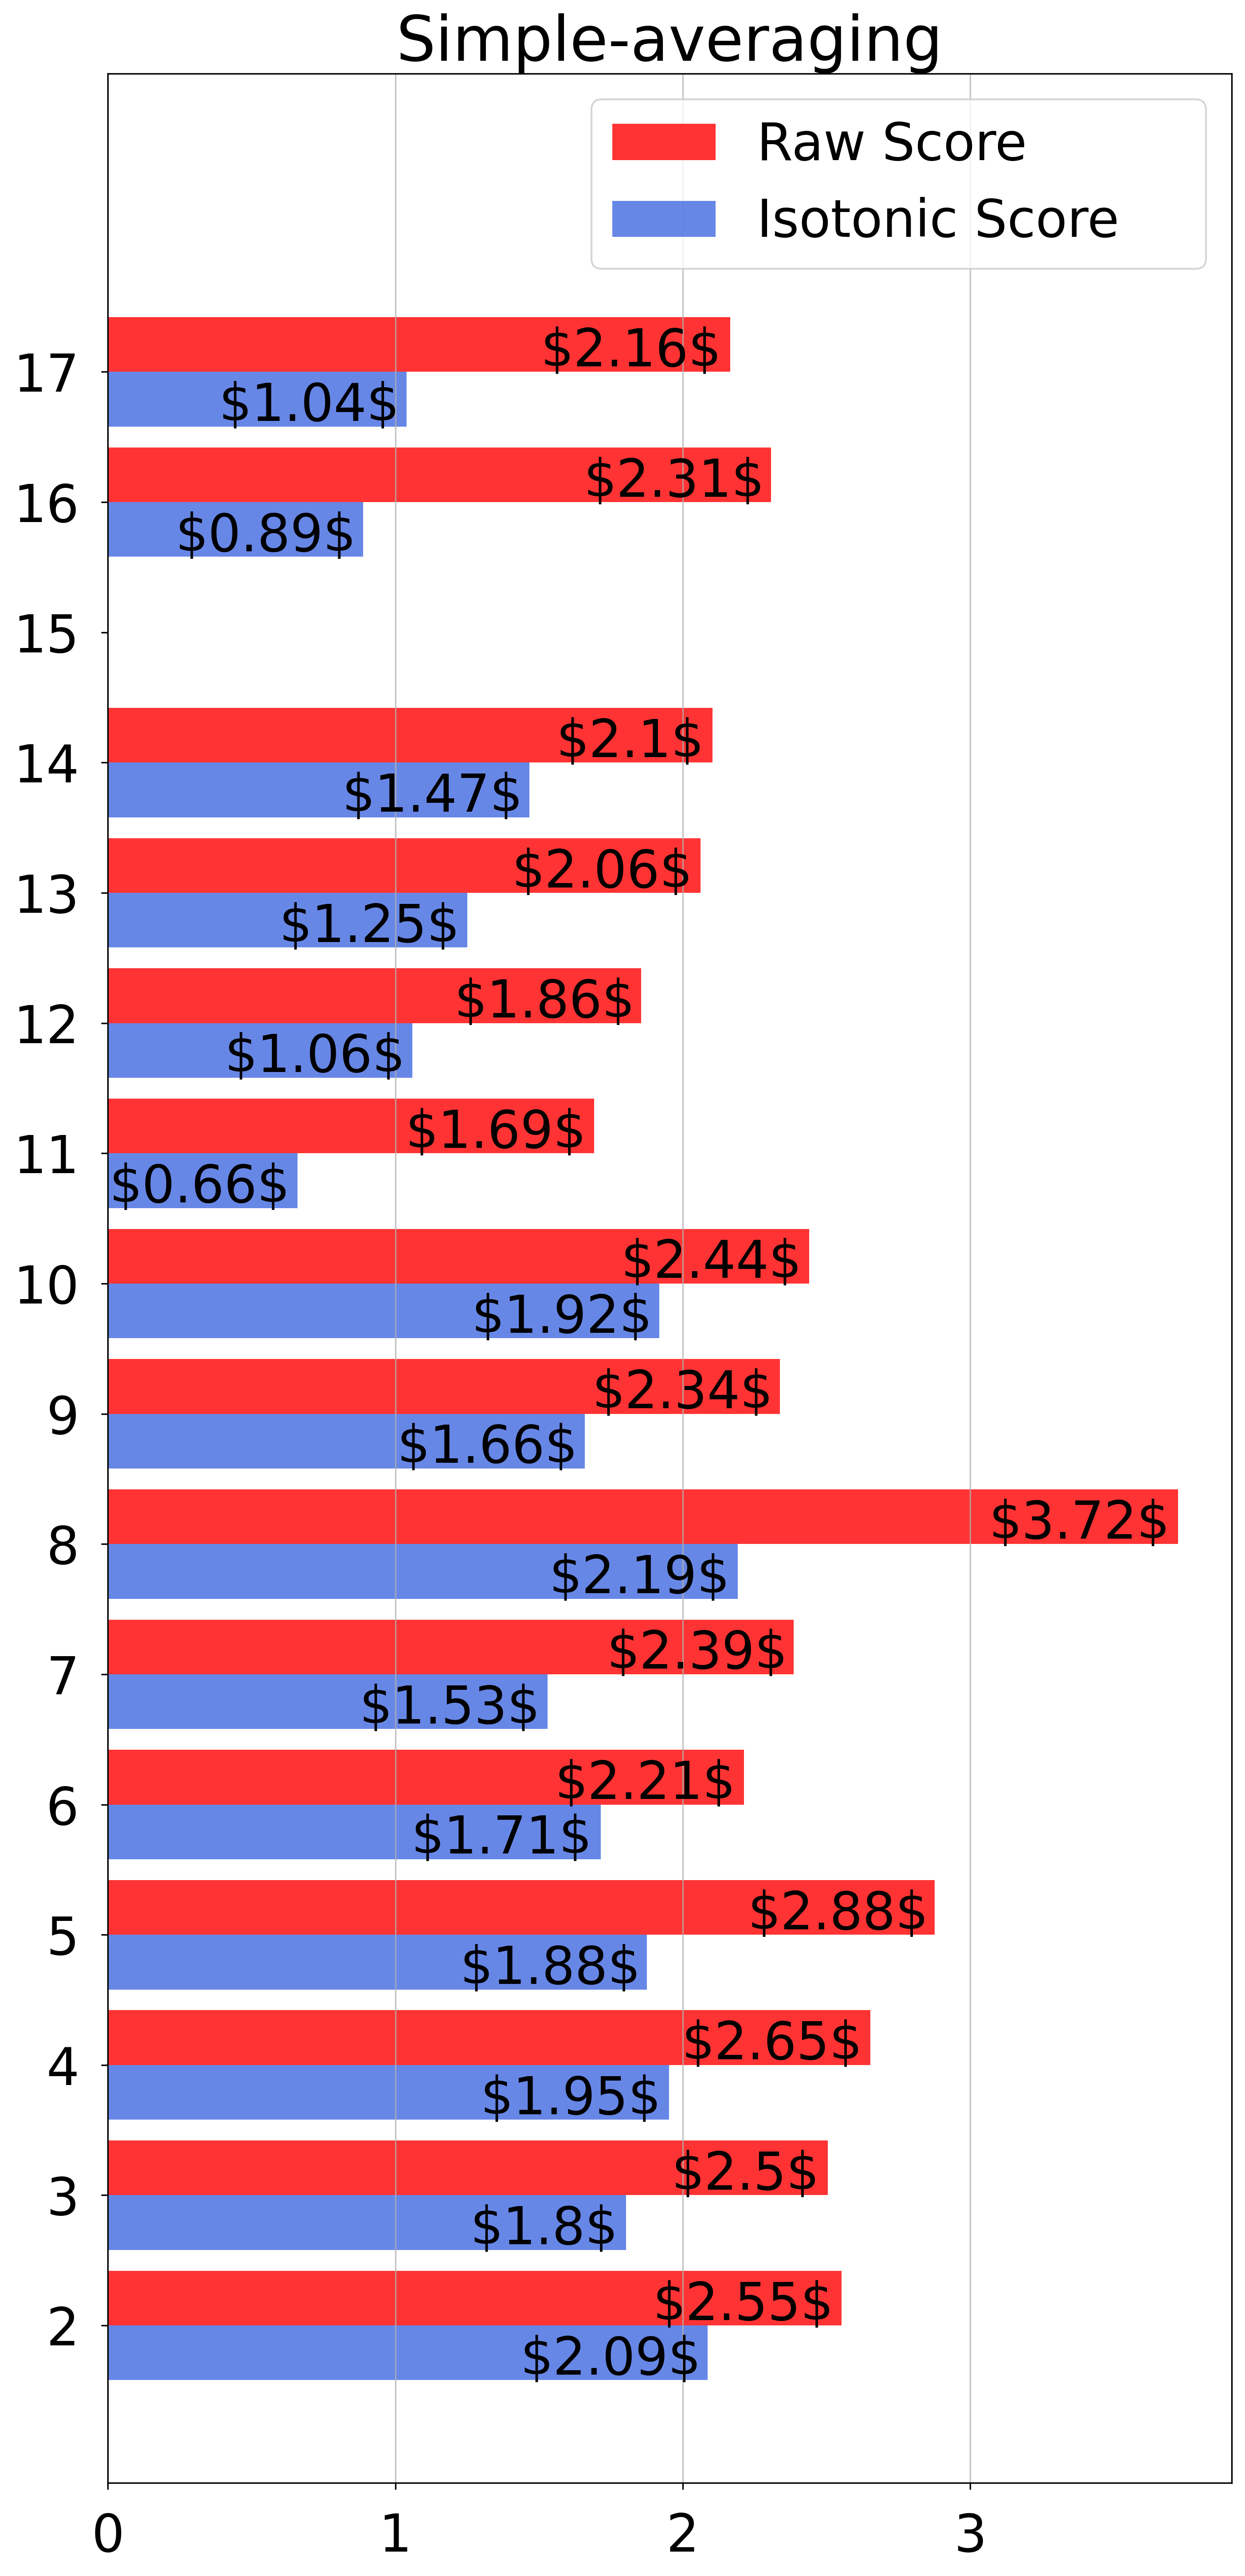

In [ ]:
# proxy
submission_true_rating = {}
for submission in final_submission_list:
    submission_true_rating[submission] = df[df['submission_idx'] == submission]['proxy'].tolist()
    submission_true_rating[submission] = submission_true_rating[submission][0]



# score
submission_old_rating = {}
for submission in final_submission_list:
    submission_old_rating[submission] = df[df['submission_idx'] == submission]['score'].tolist()
    submission_old_rating[submission] = submission_old_rating[submission][0]



# Group MSE values by the number of submissions.
old_mse_list = []
new_mse_list = []
for i in range(1, 17):
  i = i+1
  authors_i = []
  for author in authors:
    if len(author_submission_rank_true[author]) == i:
      authors_i.append(author)
  author_mse_old = {}
  author_mse_new = {}
  for author in authors_i:
    author_old_rating = []
    author_new_rating = []
    author_true_rating = []

    for submission in df[df['author_idx'] == author]['submission_idx'].tolist():
      author_old_rating.append(submission_old_rating[submission])
      author_new_rating.append(submission_new_rating[submission])
      author_true_rating.append(submission_true_rating[submission])

    author_mse_old[author] = mean_squared_error(author_true_rating, author_old_rating)
    author_mse_new[author] = mean_squared_error(author_true_rating, author_new_rating)

  author_mse_old_list = list(author_mse_old.values())
  author_mse_new_list = list(author_mse_new.values())

  author_mse_old_mean = np.mean(author_mse_old_list)
  author_mse_new_mean = np.mean(author_mse_new_list)

  old_mse_list.append(author_mse_old_mean)
  new_mse_list.append(author_mse_new_mean)

  #Perform the paired sample t-test
  t_statistic, p_value = stats.ttest_ind(author_mse_old_list, author_mse_new_list, alternative='greater')



new_mse_list = [0 if np.isnan(x) else x for x in new_mse_list]
old_mse_list = [0 if np.isnan(x) else x for x in old_mse_list]



# Generate some example data
submissions = list(range(2, 18))

# Create a figure and axis
fig, ax = plt.subplots()

# Set the total bar width (for both sets)
total_bar_width = 0.84

# Calculate the bar positions for two sets of data
bar_positions_1 = np.arange(len(submissions))
bar_positions_2 = bar_positions_1 + total_bar_width/2

# Set the individual bar width for each set
bar_width = total_bar_width / 2

# Create the horizontal bars for each set of data
bars_1 = ax.barh(bar_positions_2, old_mse_list, bar_width, alpha = 0.8, color = 'red', label='Raw Score    ')
bars_2 = ax.barh(bar_positions_1, new_mse_list, bar_width, alpha = 0.8, color = 'royalblue', label='Isotonic Score    ')


# Add labels to the bars
for bar in bars_1 + bars_2:
    width = round(bar.get_width(),2)
    if 0.90 > width > 0:
        ax.annotate(f'\${width}\$', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')
    if width > 0.90:
        ax.annotate(f'\${width}\$', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')

# Set labels, title, and legend
plt.grid(axis='x', alpha=0.75)
# ax.set_xlabel('(a) Mean Squared Error')
# ax.set_ylabel('Mean Squared Error')
ax.set_title('Simple-averaging')
ax.set_ylim(-1,17.5)
ax.set_yticks(bar_positions_1 + total_bar_width / 4)
ax.set_yticklabels(submissions)
ax.legend(loc='upper right')
ax.tick_params(axis='x', pad=12)
ax.tick_params(axis='y', pad=12)

plt.savefig("/content/drive/MyDrive/Research/ICML_2023_Result/Figures/adhoc_iso_no_submission_vertical_L2.svg", bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()


## Group L1 values by the number of submissions and Plot.


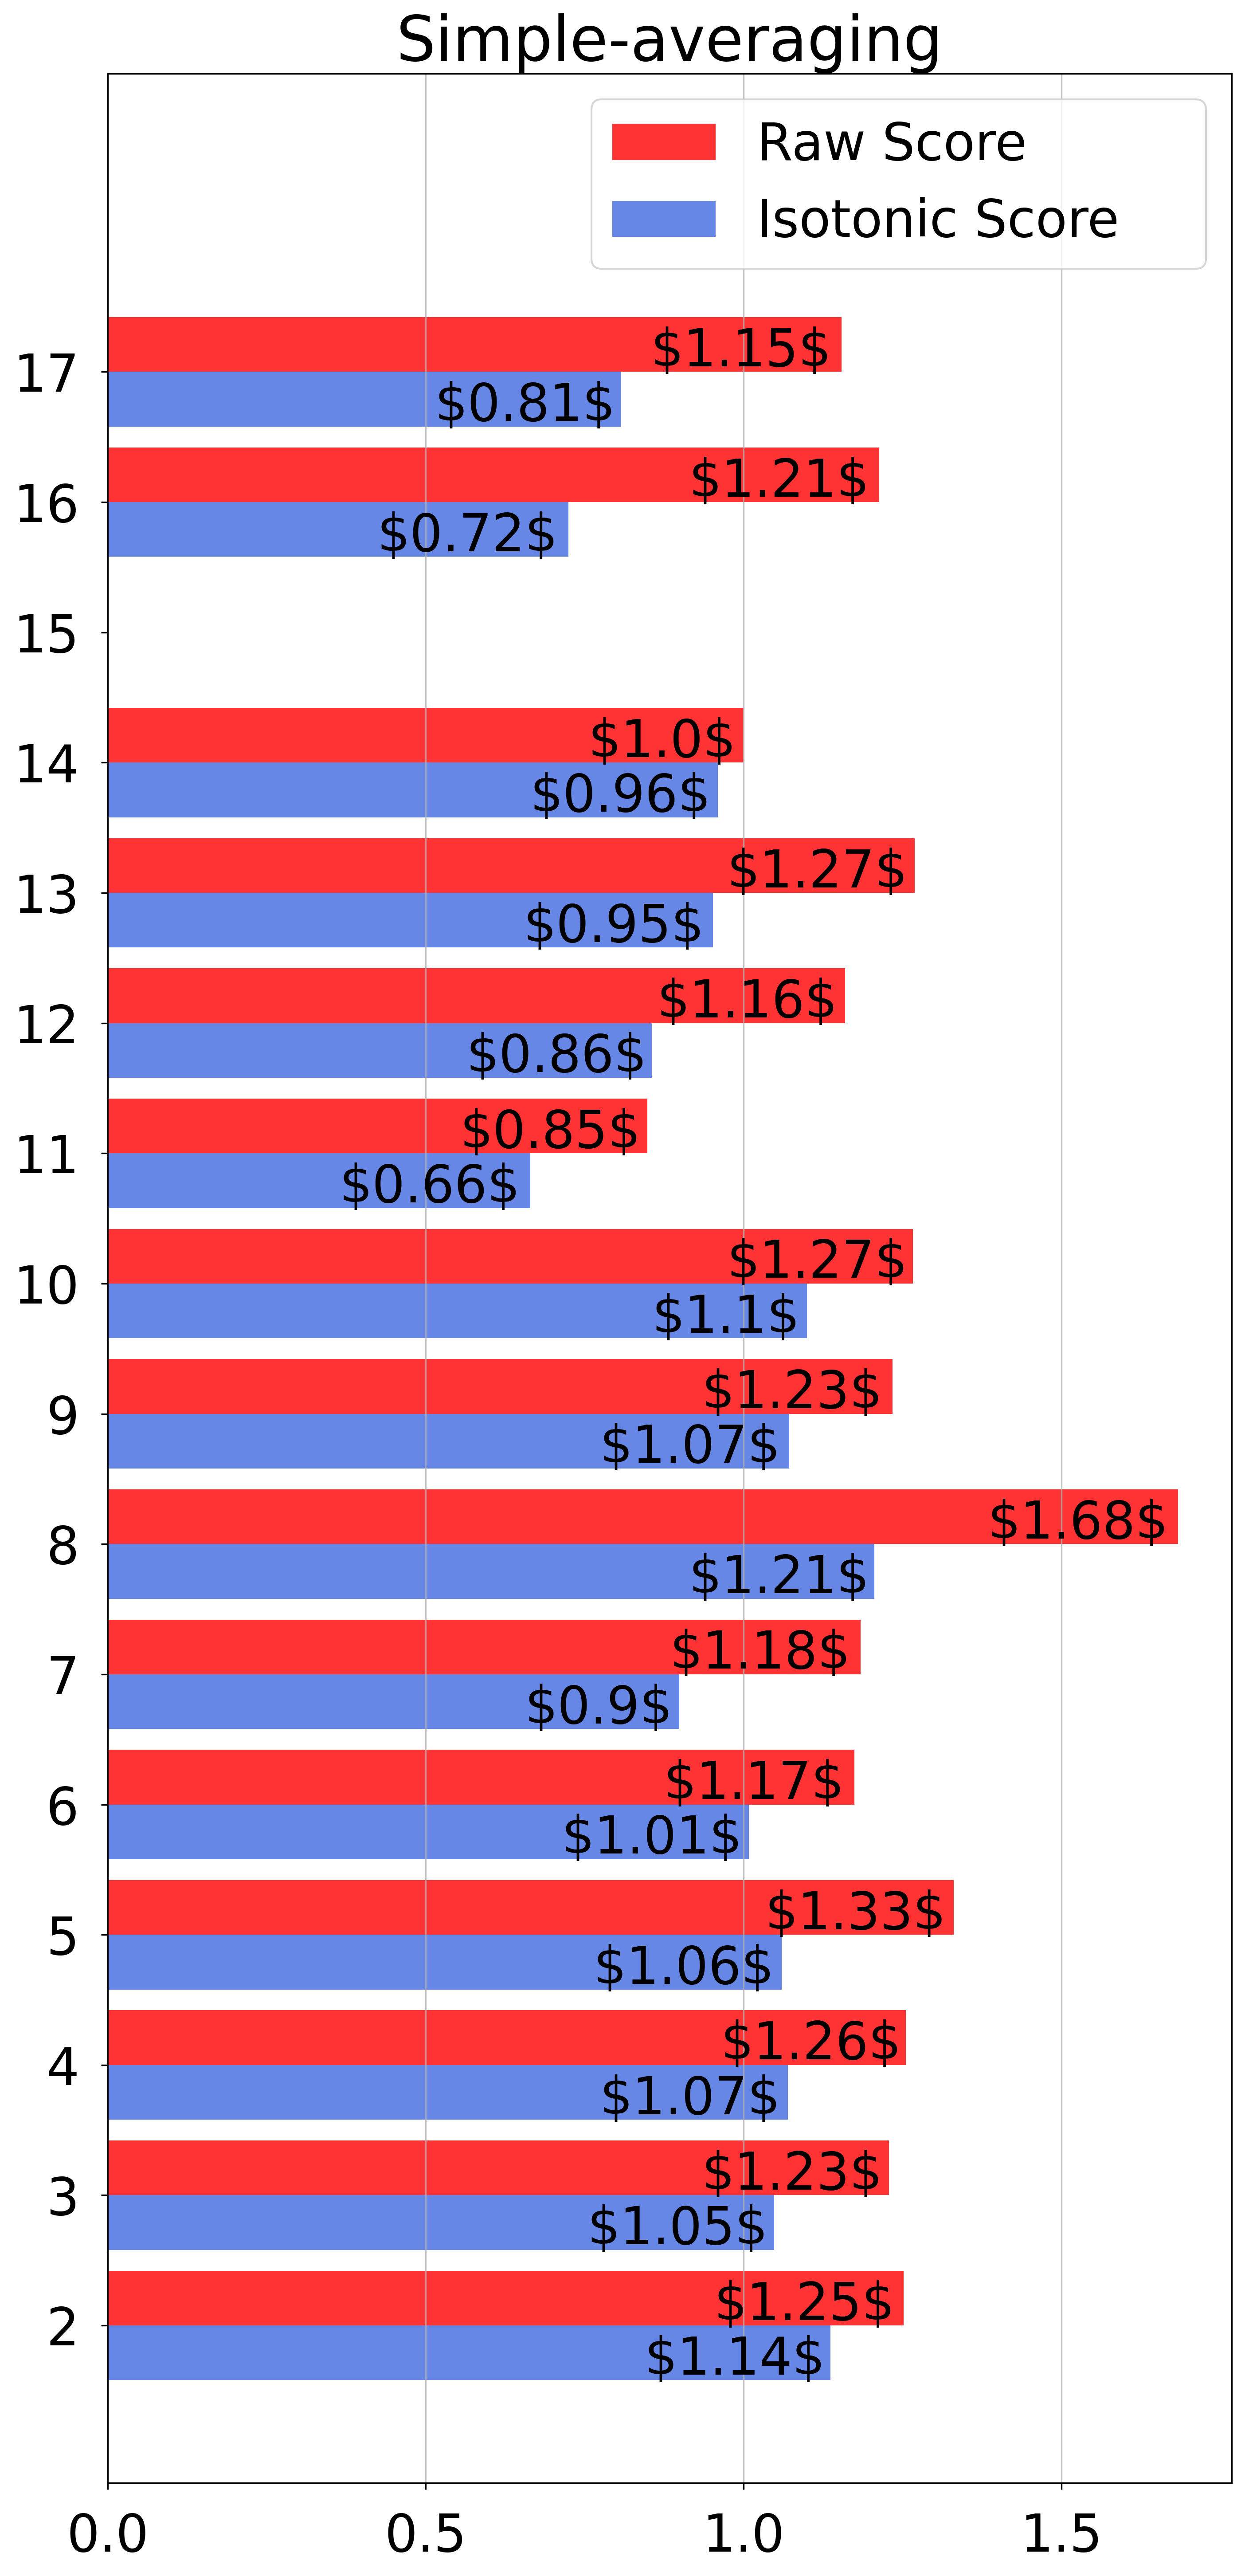

In [ ]:


# Group MSE values by the number of submissions.
old_mse_list = []
new_mse_list = []
for i in range(1, 17):
  i = i+1
  authors_i = []
  for author in authors:
    if len(author_submission_rank_true[author]) == i:
      authors_i.append(author)
  author_mse_old = {}
  author_mse_new = {}
  for author in authors_i:
    author_old_rating = []
    author_new_rating = []
    author_true_rating = []

    for submission in df[df['author_idx'] == author]['submission_idx'].tolist():
      author_old_rating.append(submission_old_rating[submission])
      author_new_rating.append(submission_new_rating[submission])
      author_true_rating.append(submission_true_rating[submission])

    old_abs = []
    new_abs = []
    for i in range(len(df[df['author_idx'] == author]['submission_idx'].tolist())):
      old_abs.append( abs(author_true_rating[i] - author_old_rating[i]) )
      new_abs.append( abs(author_true_rating[i] - author_new_rating[i]) )

    author_mse_old[author] = np.mean(old_abs)
    author_mse_new[author] = np.mean(new_abs)

  author_mse_old_list = list(author_mse_old.values())
  author_mse_new_list = list(author_mse_new.values())

  author_mse_old_mean = np.mean(author_mse_old_list)
  author_mse_new_mean = np.mean(author_mse_new_list)

  old_mse_list.append(author_mse_old_mean)
  new_mse_list.append(author_mse_new_mean)

  #Perform the paired sample t-test
  t_statistic, p_value = stats.ttest_ind(author_mse_old_list, author_mse_new_list, alternative='greater')



new_mse_list = [0 if np.isnan(x) else x for x in new_mse_list]
old_mse_list = [0 if np.isnan(x) else x for x in old_mse_list]



# Generate some example data
submissions = list(range(2, 18))

# Create a figure and axis
fig, ax = plt.subplots()

# Set the total bar width (for both sets)
total_bar_width = 0.84

# Calculate the bar positions for two sets of data
bar_positions_1 = np.arange(len(submissions))
bar_positions_2 = bar_positions_1 + total_bar_width/2

# Set the individual bar width for each set
bar_width = total_bar_width / 2

# Create the horizontal bars for each set of data
bars_1 = ax.barh(bar_positions_2, old_mse_list, bar_width, alpha = 0.8, color = 'red', label='Raw Score    ')
bars_2 = ax.barh(bar_positions_1, new_mse_list, bar_width, alpha = 0.8, color = 'royalblue', label='Isotonic Score    ')


# Add labels to the bars
for bar in bars_1 + bars_2:
    width = round(bar.get_width(),2)
    if width != 0:
        ax.annotate(f'\${width}\$', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')

# Set labels, title, and legend
plt.grid(axis='x', alpha=0.75)
# ax.set_xlabel('(d) Mean Absolute Error')
# ax.set_ylabel('Mean Squared Error')
ax.set_title('Simple-averaging')
ax.set_ylim(-1,17.5)
ax.set_yticks(bar_positions_1 + total_bar_width / 4)
ax.set_yticklabels(submissions)
ax.legend(loc='upper right')
ax.tick_params(axis='x', pad=12)
ax.tick_params(axis='y', pad=12)

plt.savefig("/content/drive/MyDrive/Research/ICML_2023_Result/Figures/adhoc_iso_no_submission_vertical_L1.svg", bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()


# **Greedy Isotonic Scores, Proxy**


## Load CSV file into a pandas DataFrame

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/Research/ICML_2023_Result/proxy_score.csv')
df = df.drop_duplicates(['submission_idx', 'author_idx'])

authors = df['author_idx'].unique()
submissions = df['submission_idx'].unique()

author_submission = {}
for author in authors:
    submissionss = df[df['author_idx'] == author]['submission_idx'].tolist()
    author_submission[author] = submissionss

m_2 = len(author_submission)
n_2 = len(submissions)

## Organize all the authors and submissions as the following 'graph': authors = [..., {..., paper_idx : ranking, ...}, ...]


In [ ]:
authors = []
for author in author_submission:
    submission_ranking = {}
    for i in range(len(author_submission[author])):
        submission_ranking[author_submission[author][i]] = df[(df['submission_idx'] == author_submission[author][i]) & (df['author_idx'] == author)]['rank'].tolist()
        submission_ranking[author_submission[author][i]] = submission_ranking[author_submission[author][i]][0]
    authors.append(submission_ranking)

graph = {}
for i, author in enumerate(authors):
    graph[i] = set( int(k) for k in author.keys())

## Greedy Isotonic

In [ ]:
# Partition all the graph according to greedy algorithm
partition, author_parts = greedy(graph, m_2, n_2)
author_parts = validate(partition, graph, n_2)
calibrated_scores = np.zeros(n_2)
for part, author_part in zip(partition, author_parts):
  if len(author_part) == 0:
    for i in part: calibrated_scores[i] = df[df['submission_idx'] == i]['score'].tolist()[0]
    continue
  paper_part = list(part)



  # Organize each block by {author: [submission, rank, score]}.
  author_submission_rank_old = {}
  for author in author_part:
    author_submission_rank_old[author] = []
    for i in range(len(paper_part)):
        rank = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['rank'].tolist()[0]
        ratings = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['score'].tolist()[0]
        author_submission_rank_old[author].append((paper_part[i], rank, ratings))



  # Sort submissions by rank; in case of ties, sort by score.
  def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
      author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old
  author_submission_rank_old = sort_submissions(author_submission_rank_old)



  # Compute isotonic scores for each author in the block.
  author_submission_rank_greedy_iso = {}
  for author in author_submission_rank_old:
      ir_rank = []
      for i in range(len(author_submission_rank_old[author])):
          r1 = author_submission_rank_old[author][i][2]
          ir_rank.append(r1)
      ir_rank = np.array(ir_rank)
      ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)

      author_submission_rank_greedy_iso[author] = []
      for i in range(len(author_submission_rank_old[author])):
          author_submission_rank_greedy_iso[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))



  # For multi-author submissions in a block, average the scores to get the isotonic score.
  submission_greedy_iso_rating = {}
  for submission in paper_part:
      submission_greedy_iso_rating[submission] = []

  for author in author_submission_rank_greedy_iso:
      for i in range(len(author_submission_rank_greedy_iso[author])):
          submission_greedy_iso_rating[author_submission_rank_greedy_iso[author][i][0]].append(author_submission_rank_greedy_iso[author][i][2])

  for submission in submission_greedy_iso_rating:
      submission_greedy_iso_rating[submission] = [float(rating) for rating in submission_greedy_iso_rating[submission]]
      avg_rating = sum(submission_greedy_iso_rating[submission])/len(submission_greedy_iso_rating[submission])
      submission_greedy_iso_rating[submission] = avg_rating

  for i in paper_part:
    calibrated_scores[i] = submission_greedy_iso_rating[i]



# Isotonic Score
submission_new_rating= {}
for i in range(n_2):
  submission_real = df[df['submission_idx'] == i]['submission_id'].tolist()[0]
  submission_new_rating[submission_real] = calibrated_scores[i]



# proxy
submission_true_rating = {}
for i in range(n_2):
    submission_real = df[df['submission_idx'] == i]['submission_id'].tolist()[0]
    submission_true_rating[submission_real] = df[df['submission_idx'] == i]['proxy'].tolist()[0]



# score
submission_old_rating = {}
for i in range(n_2):
    submission_real = df[df['submission_idx'] == i]['submission_id'].tolist()[0]
    submission_old_rating[submission_real] = df[df['submission_idx'] == i]['score'].tolist()
    submission_old_rating[submission_real] = submission_old_rating[submission_real][0]

## Group MSE values by the number of submissions.


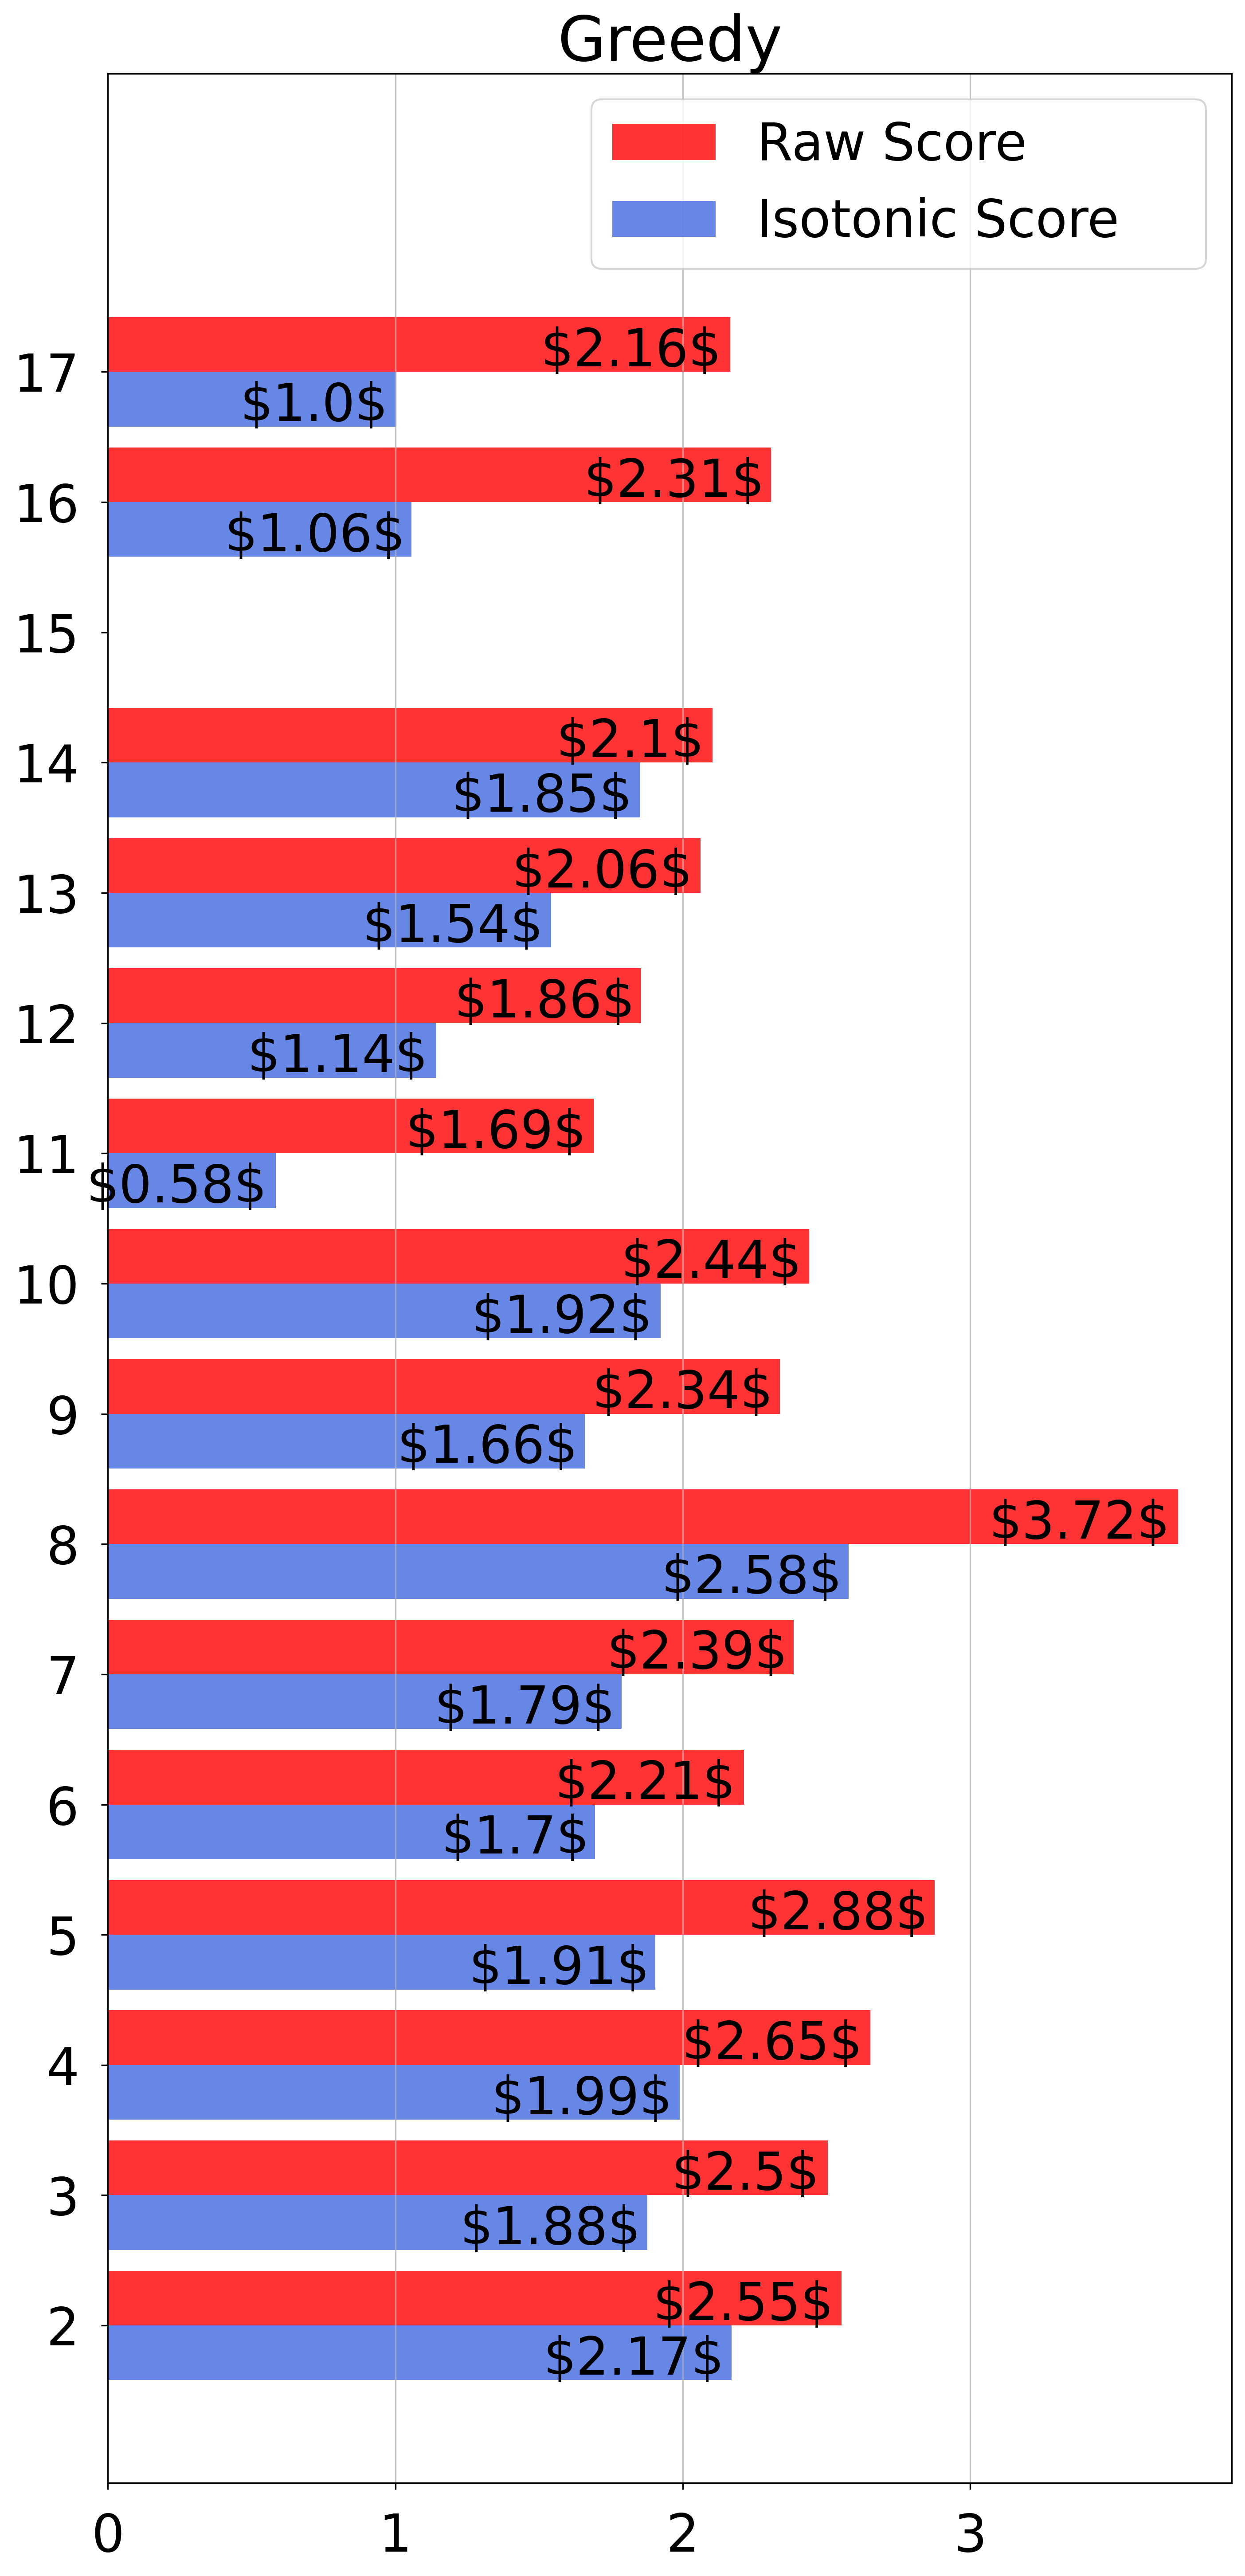

In [ ]:

authors = df['author_id'].unique()
author_submission = {}
for author in authors:
    submissionss = df[df['author_id'] == author]['submission_id'].tolist()
    author_submission[author] = submissionss

old_mse_list = []
new_mse_list = []

for i in range(1, 17):
  i = i+1
  authors_i = []
  for author in authors:
    if len(author_submission[author]) == i:
      authors_i.append(author)

  author_mse_old = {}
  author_mse_new = {}
  for author in authors_i:
    author_old_rating = []
    author_new_rating = []
    author_true_rating = []
    for submission in df[df['author_id'] == author]['submission_id'].tolist():
      author_old_rating.append(submission_old_rating[submission])
      author_new_rating.append(submission_new_rating[submission])
      author_true_rating.append(submission_true_rating[submission])


    author_mse_old[author] = mean_squared_error(author_true_rating, author_old_rating)
    author_mse_new[author] = mean_squared_error(author_true_rating, author_new_rating)

  author_mse_old_list = list(author_mse_old.values())
  author_mse_new_list = list(author_mse_new.values())

  author_mse_old_mean = np.mean(author_mse_old_list)
  author_mse_new_mean = np.mean(author_mse_new_list)

  old_mse_list.append(author_mse_old_mean)
  new_mse_list.append(author_mse_new_mean)

  #Perform the paired sample t-test
  t_statistic, p_value = stats.ttest_ind(author_mse_old_list, author_mse_new_list, alternative='greater')



new_mse_list = [0 if np.isnan(x) else x for x in new_mse_list]
old_mse_list = [0 if np.isnan(x) else x for x in old_mse_list]



# Generate some example data
submissions = list(range(2, 18))

# Create a figure and axis
fig, ax = plt.subplots()

# Set the total bar width (for both sets)
total_bar_width = 0.84

# Calculate the bar positions for two sets of data
bar_positions_1 = np.arange(len(submissions))
bar_positions_2 = bar_positions_1 + total_bar_width/2

# Set the individual bar width for each set
bar_width = total_bar_width / 2

# Create the horizontal bars for each set of data
bars_1 = ax.barh(bar_positions_2, old_mse_list, bar_width, alpha = 0.8, color = 'red', label='Raw Score    ')
bars_2 = ax.barh(bar_positions_1, new_mse_list, bar_width, alpha = 0.8, color = 'royalblue', label='Isotonic Score    ')

# Add labels to the bars
for bar in bars_1 + bars_2:
    width = round(bar.get_width(),2)
    if 0.7 > width > 0:
        ax.annotate(f'\${width}\$', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')
    if width > 0.7:
        ax.annotate(f'\${width}\$', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')

# Set labels, title, and legend
plt.grid(axis='x', alpha=0.75)
# ax.set_xlabel('(b) Mean Squared Error')
# ax.set_ylabel('Mean Squared Error')
ax.set_title('Greedy')
ax.set_ylim(-1,17.5)
ax.set_yticks(bar_positions_1 + total_bar_width / 4)
ax.set_yticklabels(submissions)
ax.legend(loc='upper right')
ax.tick_params(axis='x', pad=12)
ax.tick_params(axis='y', pad=12)

plt.savefig("/content/drive/MyDrive/Research/ICML_2023_Result/Figures/greedy_iso_no_submission_vertical_L2.svg", bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()





## Group L1 values by the number of submissions and Plot.


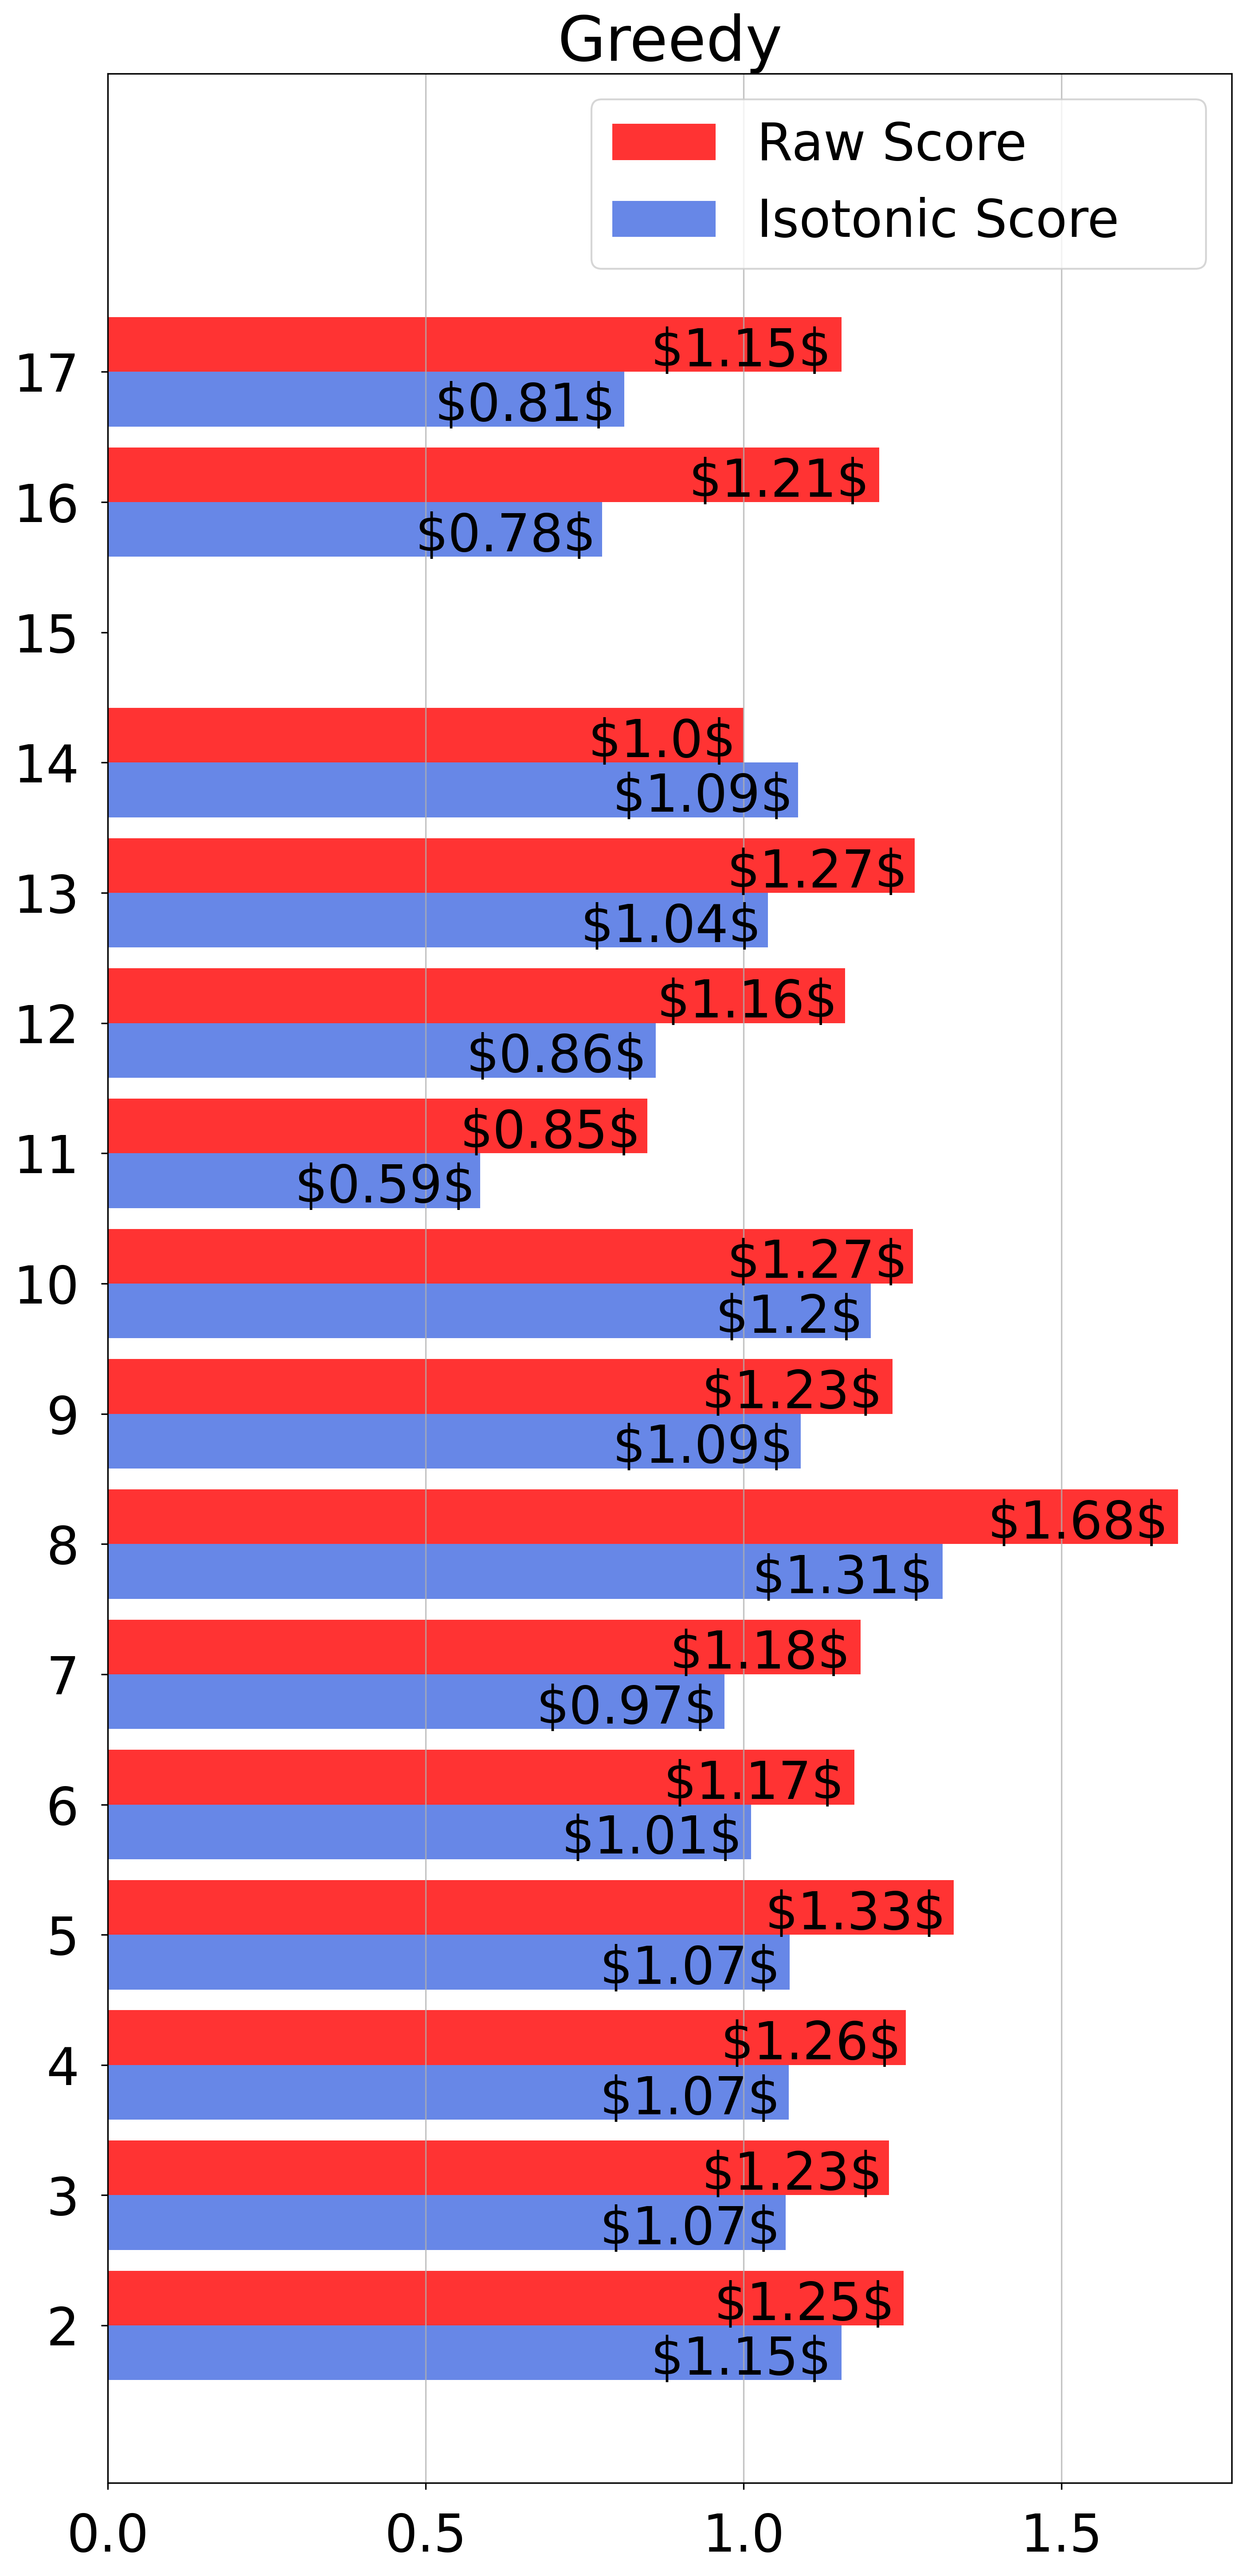

In [ ]:

authors = df['author_id'].unique()
author_submission = {}
for author in authors:
    submissionss = df[df['author_id'] == author]['submission_id'].tolist()
    author_submission[author] = submissionss

old_mse_list = []
new_mse_list = []

for i in range(1, 17):
  i = i+1
  authors_i = []
  for author in authors:
    if len(author_submission[author]) == i:
      authors_i.append(author)

  author_mse_old = {}
  author_mse_new = {}
  for author in authors_i:
    author_old_rating = []
    author_new_rating = []
    author_true_rating = []
    for submission in df[df['author_id'] == author]['submission_id'].tolist():
      author_old_rating.append(submission_old_rating[submission])
      author_new_rating.append(submission_new_rating[submission])
      author_true_rating.append(submission_true_rating[submission])

    old_abs = []
    new_abs = []
    for i in range(len(df[df['author_id'] == author]['submission_id'].tolist())):
      old_abs.append( abs(author_true_rating[i] - author_old_rating[i]) )
      new_abs.append( abs(author_true_rating[i] - author_new_rating[i]) )

    author_mse_old[author] = np.mean(old_abs)
    author_mse_new[author] = np.mean(new_abs)

  author_mse_old_list = list(author_mse_old.values())
  author_mse_new_list = list(author_mse_new.values())

  author_mse_old_mean = np.mean(author_mse_old_list)
  author_mse_new_mean = np.mean(author_mse_new_list)

  old_mse_list.append(author_mse_old_mean)
  new_mse_list.append(author_mse_new_mean)

  #Perform the paired sample t-test
  t_statistic, p_value = stats.ttest_ind(author_mse_old_list, author_mse_new_list, alternative='greater')



new_mse_list = [0 if np.isnan(x) else x for x in new_mse_list]
old_mse_list = [0 if np.isnan(x) else x for x in old_mse_list]



# Generate some example data
submissions = list(range(2, 18))

# Create a figure and axis
fig, ax = plt.subplots()

# Set the total bar width (for both sets)
total_bar_width = 0.84

# Calculate the bar positions for two sets of data
bar_positions_1 = np.arange(len(submissions))
bar_positions_2 = bar_positions_1 + total_bar_width/2

# Set the individual bar width for each set
bar_width = total_bar_width / 2

# Create the horizontal bars for each set of data
bars_1 = ax.barh(bar_positions_2, old_mse_list, bar_width, alpha = 0.8, color = 'red', label='Raw Score    ')
bars_2 = ax.barh(bar_positions_1, new_mse_list, bar_width, alpha = 0.8, color = 'royalblue', label='Isotonic Score    ')

# Add labels to the bars
for bar in bars_1 + bars_2:
    width = round(bar.get_width(),2)
    if 0.7 > width > 0:
        ax.annotate(f'\${width}\$', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')
    if width > 0.7:
        ax.annotate(f'\${width}\$', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')

# Set labels, title, and legend
plt.grid(axis='x', alpha=0.75)
# ax.set_xlabel('(e) Mean Absolute Error')
# ax.set_ylabel('Mean Squared Error')
ax.set_title('Greedy')
ax.set_ylim(-1,17.5)
ax.set_yticks(bar_positions_1 + total_bar_width / 4)
ax.set_yticklabels(submissions)
ax.legend(loc='upper right')
ax.tick_params(axis='x', pad=12)
ax.tick_params(axis='y', pad=12)

plt.savefig("/content/drive/MyDrive/Research/ICML_2023_Result/Figures/greedy_iso_no_submission_vertical_L1.svg", bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()





# **Multi-owner Isotonic Scores, Proxy**


## Load CSV file into a pandas DataFrame

In [ ]:
# Load CSV file into a pandas DataFrame
df = pd.read_csv(r'/content/drive/MyDrive/Research/ICML_2023_Result/proxy_score.csv')
df = df.drop_duplicates(['submission_idx', 'author_idx'])

# Extract the unique authors from the DataFrame
authors = df['author_idx'].unique()
submissions = df['submission_idx'].unique()

author_submission = {}
for author in authors:
    submissionss = df[df['author_idx'] == author]['submission_idx'].tolist()
    author_submission[author] = submissionss

m_2 = len(author_submission)
n_2 = len(submissions)

## Organize all the authors and submissions as the following 'graph': authors = [..., {..., paper_idx : ranking, ...}, ...]


In [ ]:
authors = []
for author in author_submission:
    submission_ranking = {}
    for i in range(len(author_submission[author])):
        submission_ranking[author_submission[author][i]] = df[(df['submission_idx'] == author_submission[author][i]) & (df['author_idx'] == author)]['rank'].tolist()
        submission_ranking[author_submission[author][i]] = submission_ranking[author_submission[author][i]][0]
    authors.append(submission_ranking)

graph = {}
for i, author in enumerate(authors):
    graph[i] = set( int(k) for k in author.keys())

## Multi-owner Isotonic


In [ ]:
# Partition all the graph according to Multi-owner algorithm
partition, author_parts = arbitrary(graph, m_2, n_2)
author_parts = validate(partition, graph, n_2)
calibrated_scores = np.zeros(n_2)
for part, author_part in zip(partition, author_parts):
  if len(author_part) == 0:
    for i in part: calibrated_scores[i] = df[df['submission_idx'] == i]['score'].tolist()[0]
    continue
  paper_part = list(part)



  # Organize each block by {author: [submission, rank, score]}.
  author_submission_rank_old = {}
  for author in author_part:
    author_submission_rank_old[author] = []
    for i in range(len(paper_part)):
        rank = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['rank'].tolist()[0]
        ratings = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['score'].tolist()[0]
        author_submission_rank_old[author].append((paper_part[i], rank, ratings))



  # Sort submissions by rank; in case of ties, sort by score.
  def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
      author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old
  author_submission_rank_old = sort_submissions(author_submission_rank_old)



  # Compute isotonic scores for each author in the block.
  author_submission_rank_multi_iso = {}
  for author in author_submission_rank_old:
      ir_rank = []
      for i in range(len(author_submission_rank_old[author])):
          r1 = author_submission_rank_old[author][i][2]
          ir_rank.append(r1)
      ir_rank = np.array(ir_rank)
      ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)

      author_submission_rank_multi_iso[author] = []
      for i in range(len(author_submission_rank_old[author])):
          author_submission_rank_multi_iso[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))




  # For multi-author submissions in a block, average the scores to get the isotonic score.
  submission_multi_iso_rating = {}
  for submission in paper_part:
      submission_multi_iso_rating[submission] = []

  for author in author_submission_rank_multi_iso:
      for i in range(len(author_submission_rank_multi_iso[author])):
          submission_multi_iso_rating[author_submission_rank_multi_iso[author][i][0]].append(author_submission_rank_multi_iso[author][i][2])

  for submission in submission_multi_iso_rating:
      submission_multi_iso_rating[submission] = [float(rating) for rating in submission_multi_iso_rating[submission]]
      avg_rating = sum(submission_multi_iso_rating[submission])/len(submission_multi_iso_rating[submission])
      submission_multi_iso_rating[submission] = avg_rating

  for i in paper_part:
    calibrated_scores[i] = submission_multi_iso_rating[i]



# Isotonic Score
submission_new_rating= {}
for i in range(n_2):
  submission_real = df[df['submission_idx'] == i]['submission_id'].tolist()[0]
  submission_new_rating[submission_real] = calibrated_scores[i]



# proxy
submission_true_rating = {}
for i in range(n_2):
    submission_real = df[df['submission_idx'] == i]['submission_id'].tolist()[0]
    submission_true_rating[submission_real] = df[df['submission_idx'] == i]['proxy'].tolist()
    submission_true_rating[submission_real] = submission_true_rating[submission_real][0]



# score
submission_old_rating = {}
for i in range(n_2):
    submission_real = df[df['submission_idx'] == i]['submission_id'].tolist()[0]
    submission_old_rating[submission_real] = df[df['submission_idx'] == i]['score'].tolist()
    submission_old_rating[submission_real] = submission_old_rating[submission_real][0]

## Group MSE values by the number of submissions and Plot.


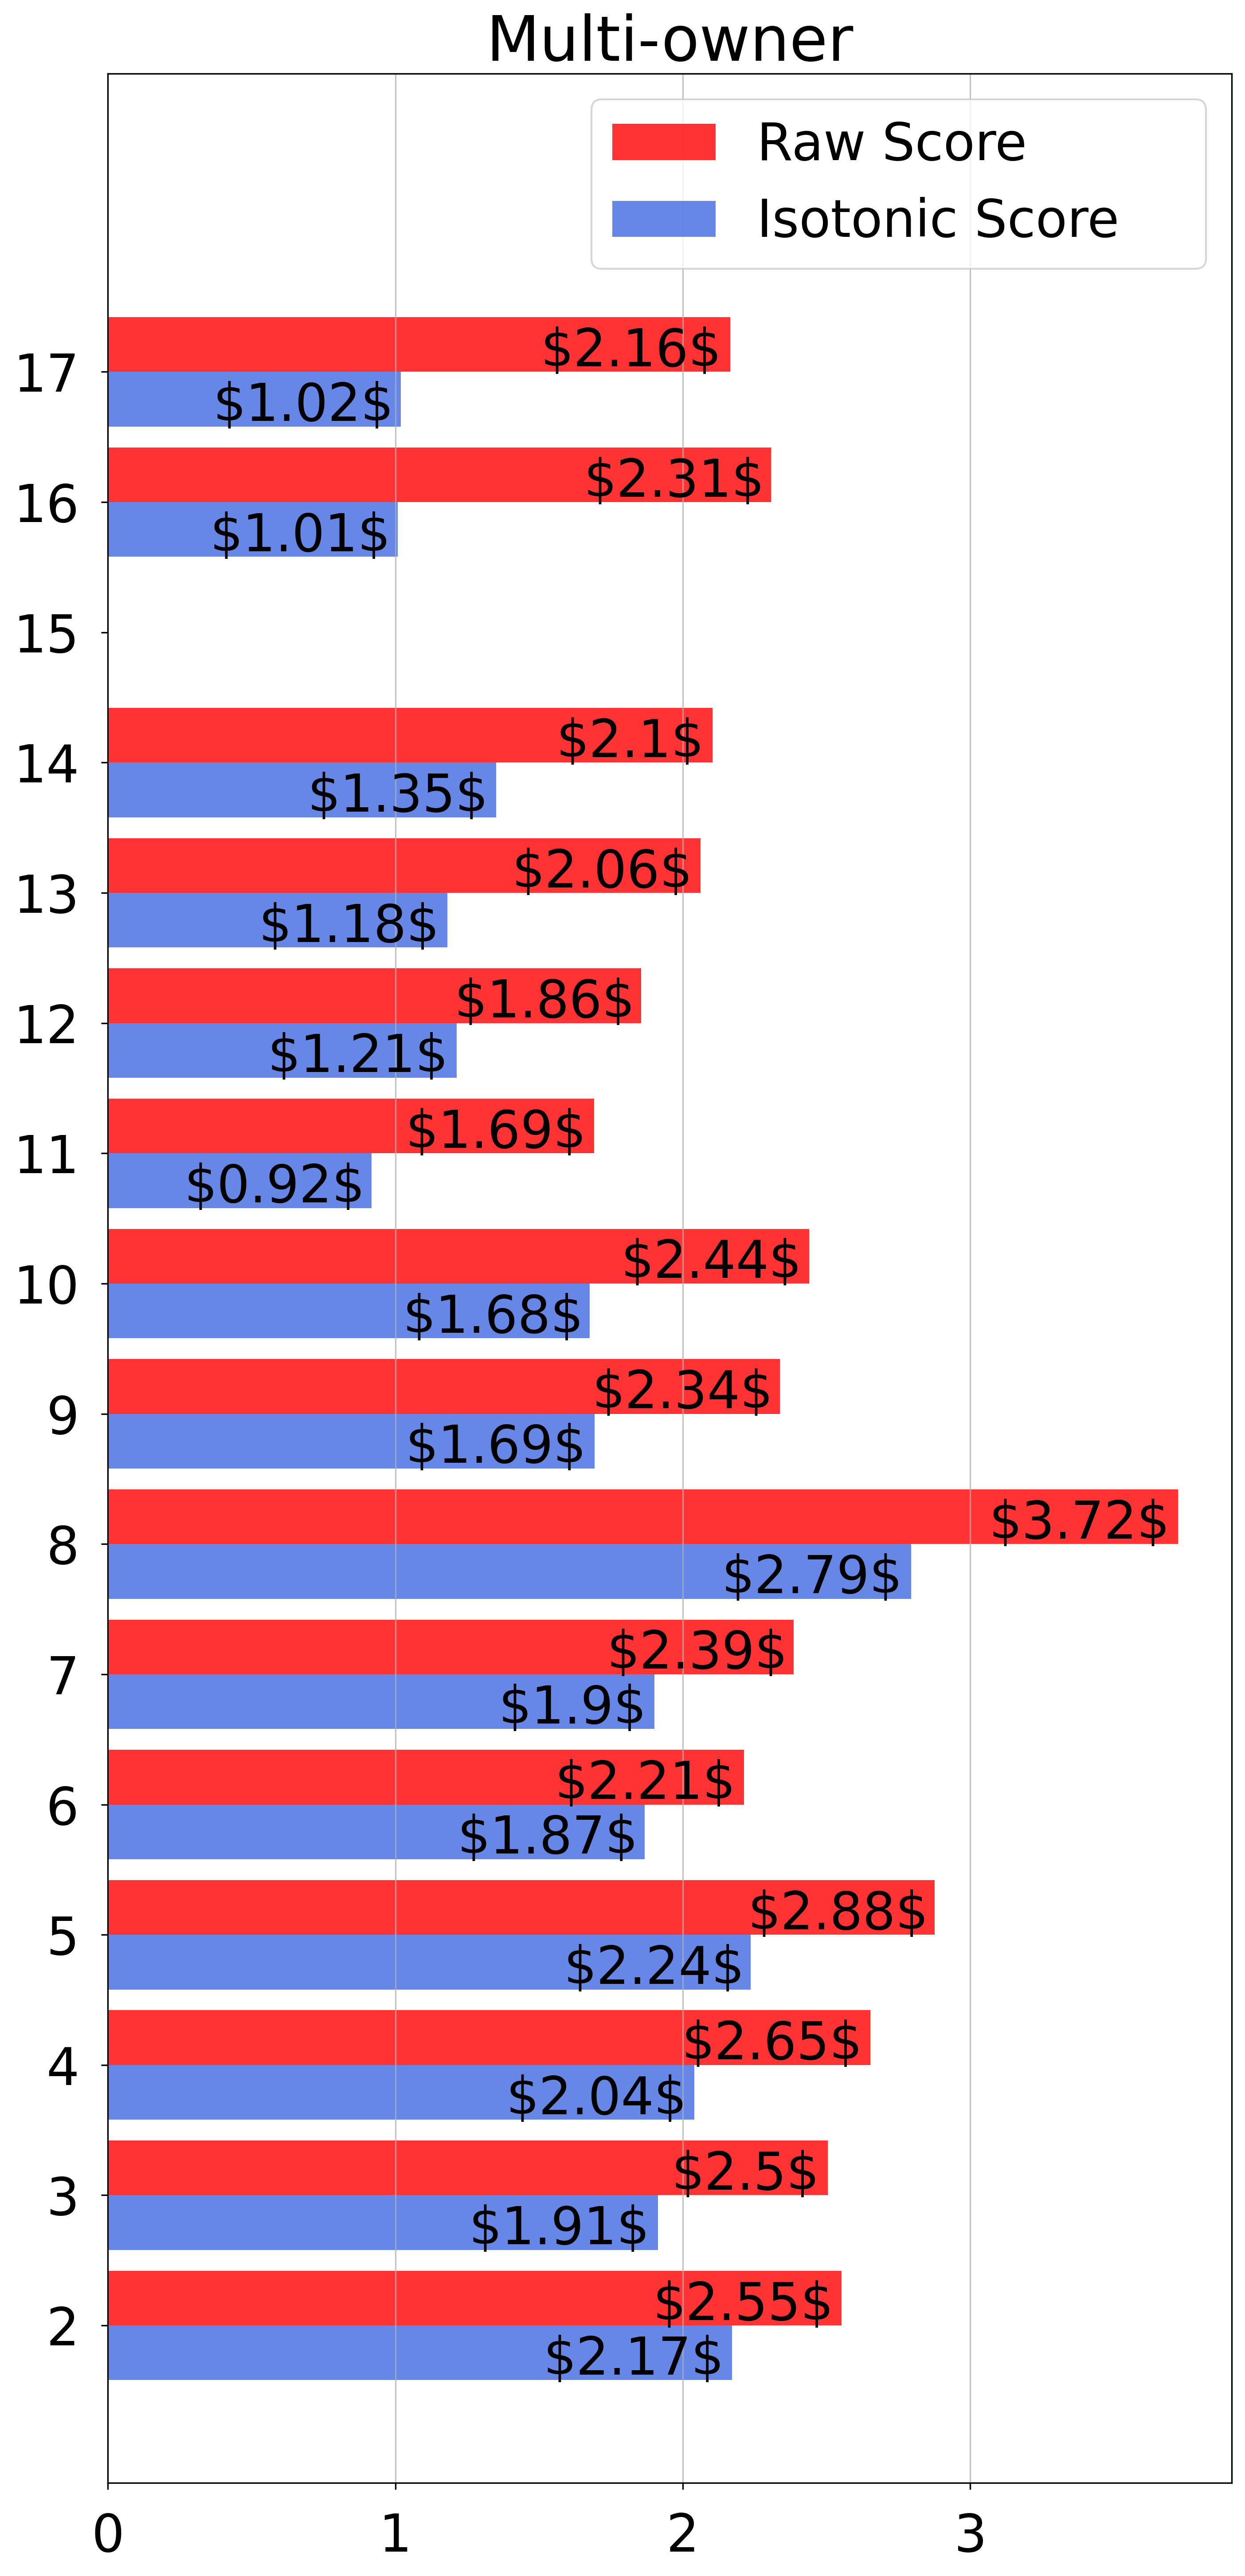

In [ ]:
authors = df['author_id'].unique()
author_submission = {}
for author in authors:
    submissionss = df[df['author_id'] == author]['submission_id'].tolist()
    author_submission[author] = submissionss


old_mse_list = []
new_mse_list = []

for i in range(1, 17):
  i = i+1
  authors_i = []
  for author in authors:
    if len(author_submission[author]) == i:
      authors_i.append(author)

  author_mse_old = {}
  author_mse_new = {}
  for author in authors_i:
    author_old_rating = []
    author_new_rating = []
    author_true_rating = []
    for submission in df[df['author_id'] == author]['submission_id'].tolist():
      author_old_rating.append(submission_old_rating[submission])
      author_new_rating.append(submission_new_rating[submission])
      author_true_rating.append(submission_true_rating[submission])


    author_mse_old[author] = mean_squared_error(author_true_rating, author_old_rating)
    author_mse_new[author] = mean_squared_error(author_true_rating, author_new_rating)

  author_mse_old_list = list(author_mse_old.values())
  author_mse_new_list = list(author_mse_new.values())

  author_mse_old_mean = np.mean(author_mse_old_list)
  author_mse_new_mean = np.mean(author_mse_new_list)

  old_mse_list.append(author_mse_old_mean)
  new_mse_list.append(author_mse_new_mean)

  #Perform the paired sample t-test
  t_statistic, p_value = stats.ttest_ind(author_mse_old_list, author_mse_new_list, alternative='greater')




new_mse_list = [0 if np.isnan(x) else x for x in new_mse_list]
# print(new_mse_list)

old_mse_list = [0 if np.isnan(x) else x for x in old_mse_list]
# print(old_mse_list)


# Generate some example data
submissions = list(range(2, 18))

# Create a figure and axis
fig, ax = plt.subplots()

# Set the total bar width (for both sets)
total_bar_width = 0.84

# Calculate the bar positions for two sets of data
bar_positions_1 = np.arange(len(submissions))
bar_positions_2 = bar_positions_1 + total_bar_width/2

# Set the individual bar width for each set
bar_width = total_bar_width / 2

# Create the horizontal bars for each set of data
bars_1 = ax.barh(bar_positions_2, old_mse_list, bar_width, alpha = 0.8, color = 'red', label='Raw Score    ')
bars_2 = ax.barh(bar_positions_1, new_mse_list, bar_width, alpha = 0.8, color = 'royalblue', label='Isotonic Score    ')

# Add labels to the bars
for bar in bars_1 + bars_2:
    width = round(bar.get_width(),2)
    if 0.93 > width > 0:
        ax.annotate(f'\${width}\$', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')
    if width > 0.93:
        ax.annotate(f'\${width}\$', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')

# Set labels, title, and legend
plt.grid(axis='x', alpha=0.75)
# ax.set_xlabel('(c) Mean Squared Error')
# ax.set_ylabel('Mean Squared Error')
ax.set_title('Multi-owner')
ax.set_ylim(-1,17.5)
ax.set_yticks(bar_positions_1 + total_bar_width / 4)
ax.set_yticklabels(submissions)
ax.legend(loc='upper right')
ax.tick_params(axis='x', pad=12)
ax.tick_params(axis='y', pad=12)

plt.savefig("/content/drive/MyDrive/Research/ICML_2023_Result/Figures/multiowner_iso_no_submission_vertical_L2.svg", bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()



## Group L1 values by the number of submissions and Plot.


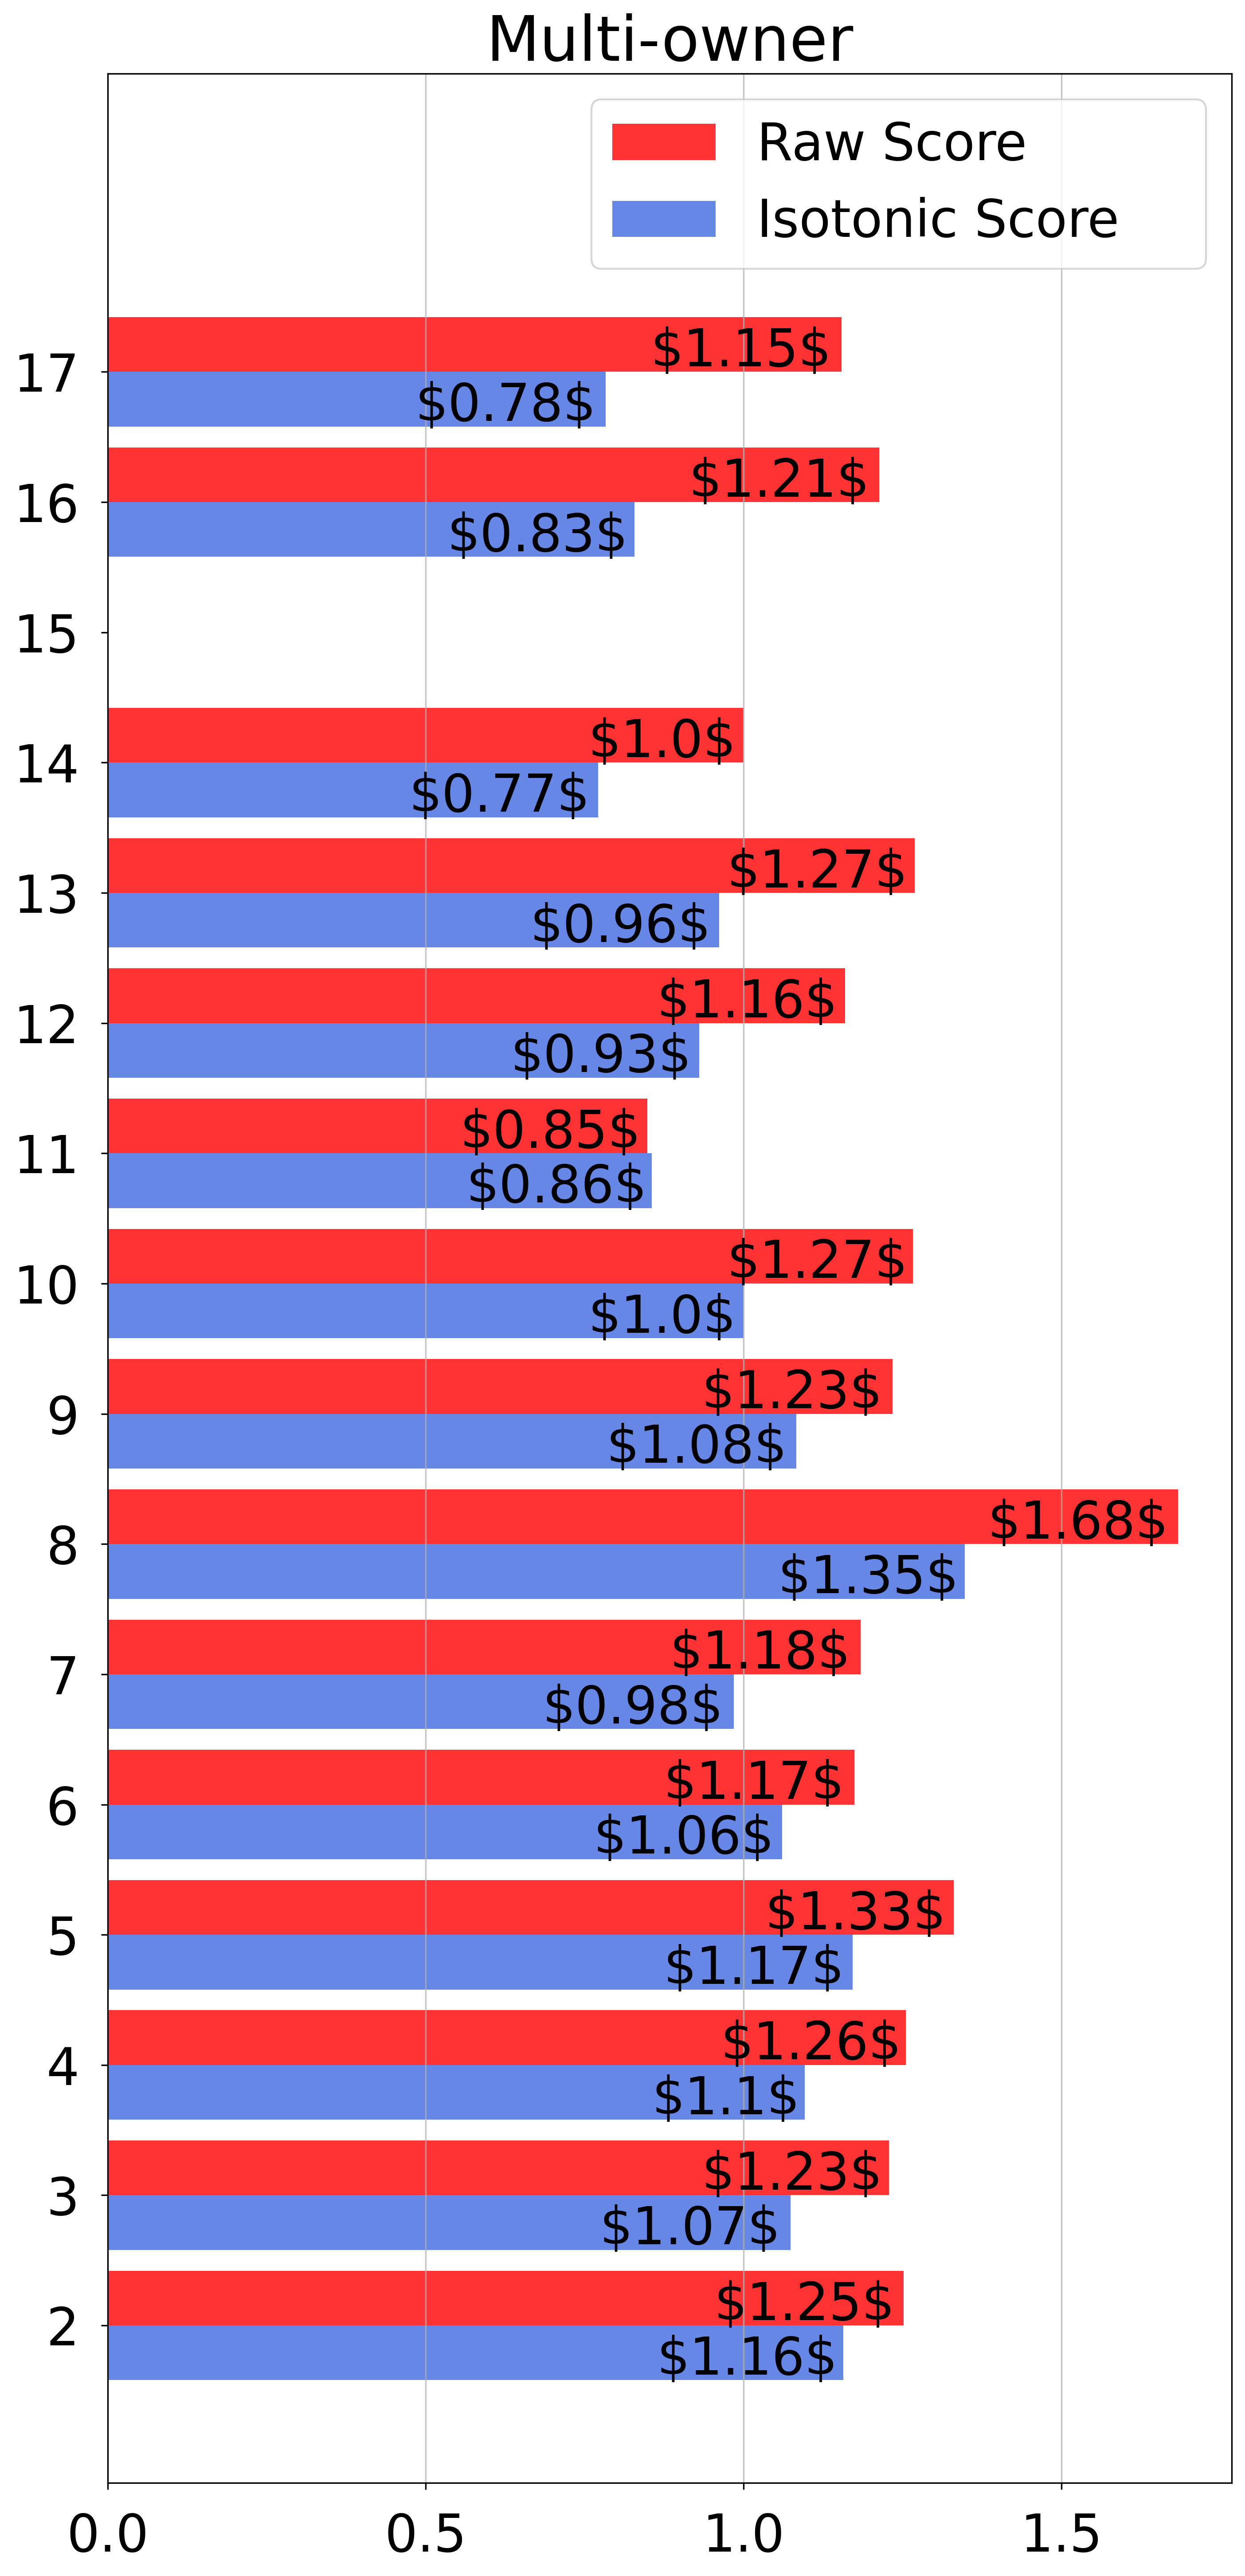

In [ ]:
authors = df['author_id'].unique()
author_submission = {}
for author in authors:
    submissionss = df[df['author_id'] == author]['submission_id'].tolist()
    author_submission[author] = submissionss


old_mse_list = []
new_mse_list = []

for i in range(1, 17):
  i = i+1
  authors_i = []
  for author in authors:
    if len(author_submission[author]) == i:
      authors_i.append(author)

  author_mse_old = {}
  author_mse_new = {}
  for author in authors_i:
    author_old_rating = []
    author_new_rating = []
    author_true_rating = []
    for submission in df[df['author_id'] == author]['submission_id'].tolist():
      author_old_rating.append(submission_old_rating[submission])
      author_new_rating.append(submission_new_rating[submission])
      author_true_rating.append(submission_true_rating[submission])

    old_abs = []
    new_abs = []
    for i in range(len(df[df['author_id'] == author]['submission_id'].tolist())):
      old_abs.append( abs(author_true_rating[i] - author_old_rating[i]) )
      new_abs.append( abs(author_true_rating[i] - author_new_rating[i]) )

    author_mse_old[author] = np.mean(old_abs)
    author_mse_new[author] = np.mean(new_abs)

  author_mse_old_list = list(author_mse_old.values())
  author_mse_new_list = list(author_mse_new.values())

  author_mse_old_mean = np.mean(author_mse_old_list)
  author_mse_new_mean = np.mean(author_mse_new_list)

  old_mse_list.append(author_mse_old_mean)
  new_mse_list.append(author_mse_new_mean)

  #Perform the paired sample t-test
  t_statistic, p_value = stats.ttest_ind(author_mse_old_list, author_mse_new_list, alternative='greater')




new_mse_list = [0 if np.isnan(x) else x for x in new_mse_list]
# print(new_mse_list)

old_mse_list = [0 if np.isnan(x) else x for x in old_mse_list]
# print(old_mse_list)


# Generate some example data
submissions = list(range(2, 18))

# Create a figure and axis
fig, ax = plt.subplots()

# Set the total bar width (for both sets)
total_bar_width = 0.84

# Calculate the bar positions for two sets of data
bar_positions_1 = np.arange(len(submissions))
bar_positions_2 = bar_positions_1 + total_bar_width/2

# Set the individual bar width for each set
bar_width = total_bar_width / 2

# Create the horizontal bars for each set of data
bars_1 = ax.barh(bar_positions_2, old_mse_list, bar_width, alpha = 0.8, color = 'red', label='Raw Score    ')
bars_2 = ax.barh(bar_positions_1, new_mse_list, bar_width, alpha = 0.8, color = 'royalblue', label='Isotonic Score    ')

# Add labels to the bars
for bar in bars_1 + bars_2:
    width = round(bar.get_width(),2)
    if width != 0:
        ax.annotate(f'\${width}\$', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')

# Set labels, title, and legend
plt.grid(axis='x', alpha=0.75)
# ax.set_xlabel('(f) Mean Absolute Error')
# ax.set_ylabel('Mean Squared Error')
ax.set_title('Multi-owner')
ax.set_ylim(-1,17.5)
ax.set_yticks(bar_positions_1 + total_bar_width / 4)
ax.set_yticklabels(submissions)
ax.legend(loc='upper right')
ax.tick_params(axis='x', pad=12)
ax.tick_params(axis='y', pad=12)

plt.savefig("/content/drive/MyDrive/Research/ICML_2023_Result/Figures/multiowner_iso_no_submission_vertical_L1.svg", bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()

